.

# Rescheduling with Deviation (vgl Wu)
> hier das Rescheduling (vereinfacht ohne neue Jobs) unter Berücksichtigung der Abweichung ausprobiert

**1. Abweichung vom Originalplan** - verändert auf Operationen-Ebene (statt Jobs)

$$
D_{0}(\sigma)
\;=\;
\sum_{o \in O'} \bigl|\;t_{o}(\sigma) - t_{o}^{0}\bigr|
\;=\;
\sum_{j \in J'} \;\sum_{m \in M}\;
\bigl|\;t_{j m}(\sigma) - t_{j m}^{0}\bigr|
$$

* $D_{0}(\sigma)$: Schedule-Deviation-Maß auf Operationsebene (Abweichung vom Originalplan)  
* $O'$: Menge aller Operationen, die nach dem Störereignis noch nicht begonnen haben  
* $J'$: Menge aller Jobs, die nach dem Störereignis noch nicht begonnen haben  
* $M$:  Menge aller Maschinen  
* $t_{o}(\sigma)$: neue Startzeit der Operation $o$ im Rescheduling-Plan $\sigma$  
* $t_{o}^{0}$: ursprünglich geplante Startzeit der Operation $o$ im Originalplan  
* $t_{j m}(\sigma)$: neue Startzeit der Operation von Job $j$ auf Maschine $m$ im Plan $\sigma$  
* $t_{j m}^{0}$: ursprünglich geplante Startzeit dieser Operation im Originalplan  


**2. Abweichung vom Right-Shift-Plan** - verändert auf Operationen-Ebene (statt Jobs)

$$
D_{1}(\sigma)
\;=\;
\sum_{o \in O'} \bigl|\;t_{o}(\sigma) - t'_{o}\bigr|
\;=\;
\sum_{j \in J'} \sum_{m \in M}
\bigl|\;t_{j m}(\sigma) - t'_{j m}\bigr|
$$

* $D_{1}(\sigma)$: Schedule-Deviation-Maß auf Operationsebene (Abweichung vom Right-Shift-Plan)  
* $O'$: Menge aller Operationen, die nach dem Störereignis noch nicht begonnen haben  
* $J'$: Menge aller Jobs, die nach dem Störereignis noch nicht begonnen haben  
* $M$:  Menge aller Maschinen  
* $t_{o}(\sigma)$: neue Startzeit der Operation $o$ im Rescheduling-Plan $\sigma$  
* $t'_{o}$: geplante Startzeit der Operation $o$ im Right-Shift-Plan  
* $t_{j m}(\sigma)$: neue Startzeit der Operation von Job $j$ auf Maschine $m$ im Plan $\sigma$  
* $t'_{j m}$: geplante Startzeit dieser Operation im Right-Shift-Plan  


## Datensatz laden und generieren

In [1]:
import json
import pandas as pd
pd.set_option('display.max_rows', 20)

# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
from ProductionDaySimulation import ProductionDaySimulation

In [2]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

In [3]:
import utils.schedule_solver__arrival as ssv_a

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

df_jssp, df_times = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [5]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


In [6]:
solver_limit = 60*60*2  #2h
solver_limit

7200

In [7]:
file_template = "data/{prefix}_schedule_{suffix}.csv"

## I. Makespan Verfahren

> Startet zu spät, keine/wenige Ops im Zeitfenster

## II. Flowtime Verfahren (gewichtet)

### a) Ursprünglicher Plan (alles)

In [8]:
df_plan = ssv_a.solve_jssp_weighted_individual_flowtime(df_jssp, df_times , solver_time_limit=solver_limit, epsilon=0.06)
df_plan

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 7200
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/dc20082158084defbc68610cd96b9231-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/dc20082158084defbc68610cd96b9231-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 7030
MIP  dc20082158084defbc68610cd96b9231-pulp has 14478 rows; 7448 cols; 42978 nonzeros; 7030 integer variables (7030 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+06]
  Cost   [3e-04, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+06]
Presolving model
14402 rows, 7410 cols, 42864 nonzeros  0s
7372 rows, 7410 cols, 21774 nonzeros  0s
7372 rows, 7410 cols, 21774 nonzeros  0s

Solving MIP model with:
   7372 rows
   7410 cols (7030 binary, 0 integer, 0 implied int., 380 continuous)
   21774 nonzeros

Src: B => Branching; C => Central rounding; 

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
375,Job_037,5,2869.61,M9,3798.57,76,1004.96,3874.57
376,Job_037,6,2869.61,M5,3874.57,47,1051.96,3921.57
377,Job_037,7,2869.61,M3,3921.57,52,1103.96,3973.57
378,Job_037,8,2869.61,M4,3973.75,90,1194.14,4063.75


In [9]:
df_plan.to_csv(file_template.format(prefix="05", suffix="00_original"), index = False)

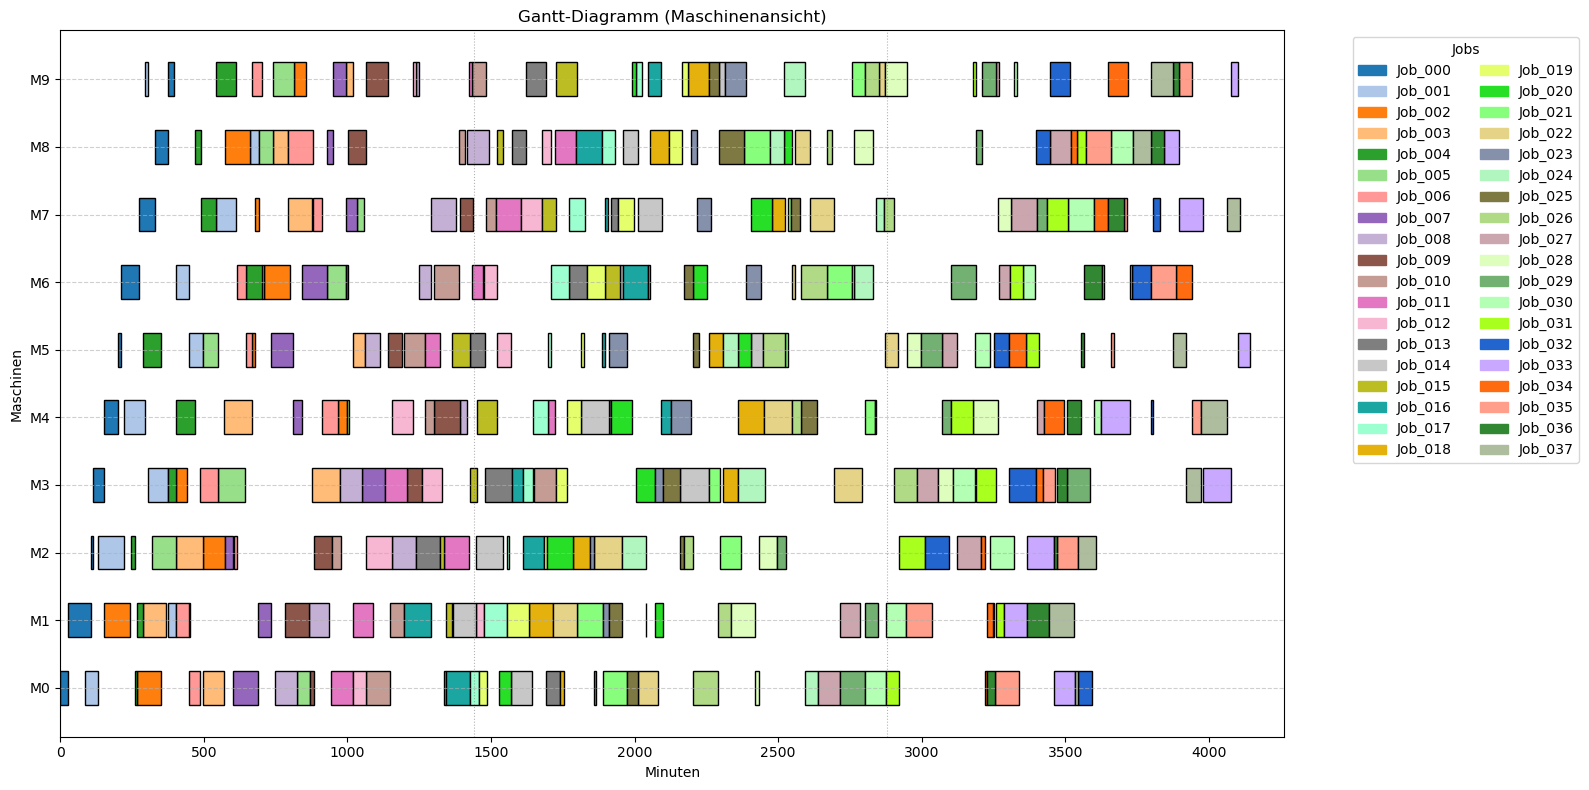

In [10]:
show.plot_gantt_machines(df_plan)

#### Simulation

In [11]:
day_start = 0
day_end = 1440

filt = (df_plan["Start"] >=  day_start) & (df_plan["Start"] < day_end)
df_schedule_filtered = df_plan[filt]
df_schedule_filtered

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
153,Job_015,3,1197.28,M5,1364.95,61,228.67,1425.95
154,Job_015,4,1197.28,M3,1425.95,26,254.67,1451.95
160,Job_016,0,1198.72,M1,1198.72,91,91.00,1289.72
161,Job_016,1,1198.72,M0,1343.01,85,229.29,1428.01


In [12]:
df_schedule_filtered

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
153,Job_015,3,1197.28,M5,1364.95,61,228.67,1425.95
154,Job_015,4,1197.28,M3,1425.95,26,254.67,1451.95
160,Job_016,0,1198.72,M1,1198.72,91,91.00,1289.72
161,Job_016,1,1198.72,M0,1343.01,85,229.29,1428.01


In [13]:
simulation = ProductionDaySimulation(df_schedule_filtered, vc=0.45)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:10:33] Job_000 finished on M0 (after 10 minutes 33 seconds)
[00:29:00] Job_000 started on M1
[01:19:31] Job_000 finished on M1 (after 50 minutes 32 seconds)
[01:28:02] Job_001 started on M0
[01:47:00] Job_000 started on M2
[02:00:32] Job_000 finished on M2 (after 13 minutes 33 seconds)
[02:00:32] Job_000 started on M3
[02:01:26] Job_001 finished on M0 (after 33 minutes 24 seconds)
[02:11:03] Job_001 started on M2
[02:32:46] Job_002 started on M1
[03:00:31] Job_000 finished on M3 (after 59 minutes 59 seconds)
[03:00:31] Job_000 started on M4
[03:26:11] Job_001 finished on M2 (after 75 minutes 08 seconds)
[04:06:36] Job_004 started on M2
[04:09:09] Job_000 finished on M4 (after 68 minutes 37 seconds)
[04:09:09] Job_001 started on M4
[04:09:09] Job_000 started on M5
[04:11:52] Job_002 finished on M1 (after 99 minutes 06 seconds)
[04:17:00] Job_000 finished on M5 (after 07 minutes 52 seconds)
[04:17:00] Job_000 started on M6
[04:26:40] Job_002 started o

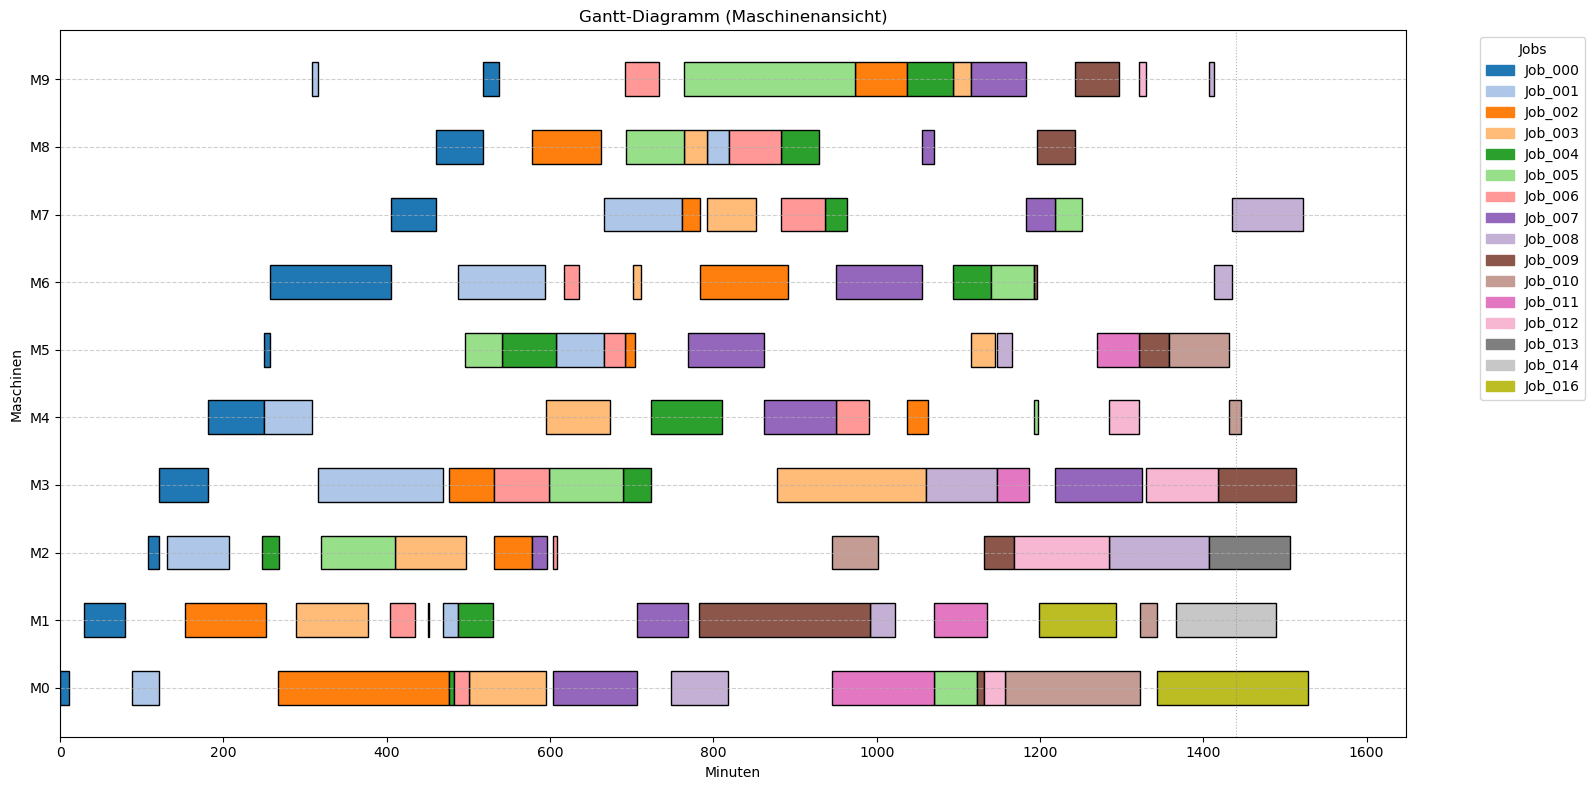

In [14]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print("⚠️ Kein Gantt-Diagramm: df_execution ist leer.")

In [15]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
4,Job_010,5,891.94,M6,1301.83,88
2,Job_009,8,781.95,M4,1301.89,90
12,Job_015,0,1197.28,M2,1322.95,14
13,Job_015,1,1197.28,M0,1336.95,6
7,Job_011,4,944.71,M2,1337.01,85
14,Job_015,2,1197.28,M1,1342.95,22
15,Job_015,3,1197.28,M5,1364.95,61
10,Job_013,1,1185.73,M1,1365.01,2
5,Job_010,6,891.94,M8,1389.83,19
3,Job_009,9,781.95,M7,1391.89,45


### b) Plan nach Simulation (Rescheduling)

In [16]:
# Filtern (nach Simulation)
day_end_prev = day_end


time_filter = (df_times["Arrival"] >= day_end_prev)

df_times_filtered = df_times[time_filter]


df_jssp_filtered = df_jssp[df_jssp["Job"].isin(df_times_filtered["Job"])]
df_jssp_filtered

,Job,Operation,Machine,Processing Time
190,Job_019,0,M0,29
191,Job_019,1,M1,78
192,Job_019,2,M2,9
193,Job_019,3,M3,36
194,Job_019,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [17]:
# Nicht gestarte Operationen ergänzen
df_jssp_filtered = rp_proced.extend_with_undone_operations(df_jssp_filtered, df_undone)
df_jssp_filtered

,Job,Operation,Machine,Processing Time
0,Job_010,5,M6,88
1,Job_009,8,M4,90
2,Job_015,0,M2,14
3,Job_015,1,M0,6
4,Job_011,4,M2,85
...,...,...,...,...
203,Job_037,5,M9,76
204,Job_037,6,M5,47
205,Job_037,7,M3,52
206,Job_037,8,M4,90


In [18]:
df_times_filtered = rp_proced.update_times_after_operation_changes(df_times, df_jssp_filtered)
df_times_filtered

,Job,Arrival
0,Job_008,748.04
1,Job_009,781.95
2,Job_010,891.94
3,Job_011,944.71
4,Job_013,1185.73
...,...,...
21,Job_033,2630.89
22,Job_034,2637.28
23,Job_035,2638.72
24,Job_036,2764.04


In [19]:
# relevante Bedingungen aus der Simulation
df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_end_prev)
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
87,Job_008,7,748.04,M7,1435.14,87.11,774.21,1522.25
95,Job_009,7,781.95,M3,1418.04,95.68,731.77,1513.72
100,Job_010,4,891.94,M4,1431.62,15.03,554.71,1446.65
110,Job_013,0,1185.73,M2,1407.31,99.34,320.92,1506.65
111,Job_014,0,1190.89,M1,1367.07,122.50,298.68,1489.57
113,Job_016,1,1198.72,M0,1343.01,185.29,329.58,1528.30


### Zielfunktion:

$$
\min \;\; Z(\sigma) \;=\; r\,F(\sigma) \;+\; (1 - r)\,D(\sigma)
$$

* $\sigma$: Der nach dem Rescheduling erzeugte Plan  
* $Z(\sigma)$: Gesamtzielwert für Plan $\sigma$ unter Berücksichtigung beider Kriterien  
* $r\in[0,1]$: Gewichtungsfaktor für das **Effizienzkriterium**

---

### Effizienzkomponente (gewichtete Flow-Time):

$$
F(\sigma) = \sum_{j \in \mathcal{J}} w_j \cdot (C_j - a_j)
$$

* $C_j$: Fertigstellungszeit von Job $j$  
* $a_j$: Ankunftszeit von Job $j$  
* $w_j = \frac{1}{1 + a_j}$: Gewicht zur Priorisierung früher eintreffender Jobs  
* $\mathcal{J}$: Menge aller Jobs

---

### Stabilitätskomponente (Startzeitabweichung):

$$
D(\sigma) = \sum_{(j,o) \in \mathcal{O}} \left| t_{j,o} - t^{\text{orig}}_{j,o} \right|
$$

* $t_{j,o}$: Startzeit der $o$-ten Operation von Job $j$ im neuen Plan  
* $t^{\text{orig}}_{j,o}$: Startzeit derselben Operation im ursprünglichen Plan  
* $\mathcal{O}$: Menge aller Operationen mit bekanntem Originalstart

---

* $r \in [0,1]$: Gewichtung der Effizienz gegenüber der Stabilität  
* Ziel: Finde **Plan $\sigma$**, der einen Kompromiss aus **Effizienz (Flow-Time)** und **Stabilität (Startzeitabweichung)** **minimiert**


In [20]:
import pandas as pd
import pulp
import re

def solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp: pd.DataFrame,
    df_arrivals: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    r: float = 0.5,
    solver_time_limit: int = 300,
    epsilon: float = 0.0,
    arrival_column: str = "Arrival",
    reschedule_start: float = 1440.0
) -> pd.DataFrame:
    """
    Bi-kriterielle Rescheduling-Variante mit fixierten Operationen.
    Zielfunktion: Z(σ) = r * F(σ) + (1 - r) * D(σ)
    - F(σ): gewichtete individuelle Flow-Times
    - D(σ): Abweichung vom Originalplan

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time']
    - df_arrivals: DataFrame mit ['Job', arrival_column]
    - df_executed: DataFrame mit ['Job','Machine','Start','End']
    - df_original_plan: DataFrame mit ['Job','Operation','Start'] als Ursprungsplan
    - r: Gewichtung für Effizienz (F) vs. Stabilität (D)
    - solver_time_limit: max. Solverzeit in Sekunden
    - epsilon: Zeitpuffer zwischen Operationen auf gleicher Maschine
    - arrival_column: Name der Spalte mit Ankunftszeit
    - reschedule_start: Zeitpunkt, ab dem neu geplant wird

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Machine','Start','Processing Time','Flow time','End']
    """

    # Vorbereitung
    df_arrivals = df_arrivals.sort_values(arrival_column).reset_index(drop=True)
    arrival_times = df_arrivals.set_index('Job')[arrival_column].to_dict()
    job_list = df_arrivals['Job'].tolist()
    num_jobs = len(job_list)
    weights = {job: 1.0 / (1.0 + arrival_times[job]) for job in job_list}

    # Originale Startzeiten extrahieren
    original_start_times = {
        (row['Job'], row['Operation']): row['Start']
        for _, row in df_original_plan.iterrows()
    }

    # Operationen & Maschinen
    ops_grouped = df_jssp.sort_values(['Job', 'Operation']).groupby('Job')
    all_ops, all_machines = [], set()
    for job in job_list:
        grp = ops_grouped.get_group(job)
        ops = []
        for _, row in grp.iterrows():
            op_id = row['Operation']
            mac_str = str(row['Machine'])
            m_id = int(re.search(r"M(\d+)", mac_str).group(1))
            dur = float(row['Processing Time'])
            ops.append((op_id, m_id, dur))
            all_machines.add(m_id)
        all_ops.append(ops)

    # Fixierte Operationen
    df_executed_fixed = df_executed[df_executed['End'] >= reschedule_start].copy()
    df_executed_fixed['MachineID'] = df_executed_fixed['Machine'].astype(str).str.extract(r"M(\d+)", expand=False).astype(int)
    fixed_ops = {
        m: list(gr[['Start', 'End', 'Job']].itertuples(index=False, name=None))
        for m, gr in df_executed_fixed.groupby('MachineID')
    }
    last_executed_end = df_executed.groupby('Job')['End'].max().to_dict()

    # LP-Modell
    prob = pulp.LpProblem('JSSP_BiCriteria_FlowDeviation_Fixed', pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0)
        for j in range(num_jobs)
        for o in range(len(all_ops[j]))
    }
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0)
        for j in range(num_jobs)
    }

    # Flow-Teil der Zielfunktion
    flow_efficiency = pulp.lpSum(
        weights[job_list[j]] * (job_ends[j] - arrival_times[job_list[j]])
        for j in range(num_jobs)
    )

    # Abweichungs-Teil der Zielfunktion
    deviations = {}
    for (j, o) in starts:
        job = job_list[j]
        key = (job, o)
        if key in original_start_times:
            dev = pulp.LpVariable(f"dev_{j}_{o}", lowBound=0)
            prob += dev >= starts[(j, o)] - original_start_times[key]
            prob += dev >= original_start_times[key] - starts[(j, o)]
            deviations[(j, o)] = dev
    deviation = pulp.lpSum(deviations.values())

    # Kombinierte Zielfunktion
    prob += r * flow_efficiency + (1 - r) * deviation

    # Technologische Reihenfolge + frühester Start
    for j, job in enumerate(job_list):
        earliest = max(arrival_times[job], last_executed_end.get(job, reschedule_start))
        prob += starts[(j, 0)] >= earliest
        for o in range(1, len(all_ops[j])):
            _, _, prev_dur = all_ops[j][o-1]
            prob += starts[(j, o)] >= starts[(j, o-1)] + prev_dur

    # Maschinenkonflikte
    M = 1e5
    for m in sorted(all_machines):
        ops_on_m = [
            (j, o, all_ops[j][o][2])
            for j in range(num_jobs)
            for o, (_, mach, _) in enumerate(all_ops[j])
            if mach == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i+1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat='Binary')
                prob += (starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + M*(1 - y))
                prob += (starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + M*y)
        for j1, o1, d1 in ops_on_m:
            for fixed_start, fixed_end, fixed_job in fixed_ops.get(m, []):
                y_fix = pulp.LpVariable(f"y_fix_{j1}_{o1}_{fixed_job}", cat='Binary')
                prob += (starts[(j1, o1)] + d1 + epsilon <= fixed_start + M*(1 - y_fix))
                prob += (fixed_end + epsilon <= starts[(j1, o1)] + M*y_fix)

    # Endzeitbindung pro Job
    for j in range(num_jobs):
        last_o = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_o)] + all_ops[j][last_o][2]

    # Solver starten
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))

    # Ergebnisse sammeln
    recs = []
    for (j, o), var in sorted(starts.items()):
        st = var.varValue
        if st is None:
            continue
        op_id, mach, dur = all_ops[j][o]
        end = st + dur
        recs.append({
            'Job': job_list[j],
            'Operation': op_id,
            'Arrival': arrival_times[job_list[j]],
            'Machine': f"M{mach}",
            'Start': round(st, 2),
            'Processing Time': dur,
            'Flow time': round(end - arrival_times[job_list[j]], 2),
            'End': round(end, 2)
        })

    df_schedule = pd.DataFrame(recs)
    df_schedule = df_schedule[['Job', 'Operation', 'Arrival', 'Machine', 'Start', 'Processing Time', 'Flow time', 'End']]
    df_schedule = df_schedule.sort_values(['Arrival', 'Start']).reset_index(drop=True)
    print("✅ Fertig mit bi-kriteriellem Rescheduling!")
    return df_schedule


In [21]:
df_reschedule = solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp = df_jssp_filtered,
    df_arrivals = df_times_filtered,
    df_executed=df_execution_important,
    df_original_plan=df_plan,
    r = 0.3,  # z. B. 30 % Effizienz, 70 % Stabilität
    solver_time_limit = solver_limit,
    reschedule_start = 1440
)
df_reschedule

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 7200
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/8b243eed40dc445a9d25c38033c5c3f5-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/8b243eed40dc445a9d25c38033c5c3f5-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 2184
MIP  8b243eed40dc445a9d25c38033c5c3f5-pulp has 5018 rows; 2626 cols; 14130 nonzeros; 2184 integer variables (2184 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e-04, 7e-01]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
4927 rows, 2556 cols, 13925 nonzeros  0s
3415 rows, 2546 cols, 9514 nonzeros  0s
3361 rows, 2516 cols, 9406 nonzeros  0s

Solving MIP model with:
   3361 rows
   2516 cols (2118 binary, 0 integer, 0 implied int., 398 continuous)
   9406 nonzeros

Src: B => Branching; C => Central rounding; F => 

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_008,8,748.04,M4,1522.25,26.0,800.21,1548.25
1,Job_008,9,748.04,M8,1553.65,74.0,879.61,1627.65
2,Job_009,8,781.95,M4,1548.25,90.0,856.30,1638.25
3,Job_009,9,781.95,M7,1638.25,45.0,901.30,1683.25
4,Job_010,5,891.94,M6,1446.65,88.0,642.71,1534.65
...,...,...,...,...,...,...,...,...
203,Job_037,5,2869.61,M9,3798.57,76.0,1004.96,3874.57
204,Job_037,6,2869.61,M5,3874.57,47.0,1051.96,3921.57
205,Job_037,7,2869.61,M3,3921.57,52.0,1103.96,3973.57
206,Job_037,8,2869.61,M4,3973.75,90.0,1194.14,4063.75


In [22]:
check.check_all_constraints(df_reschedule)

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

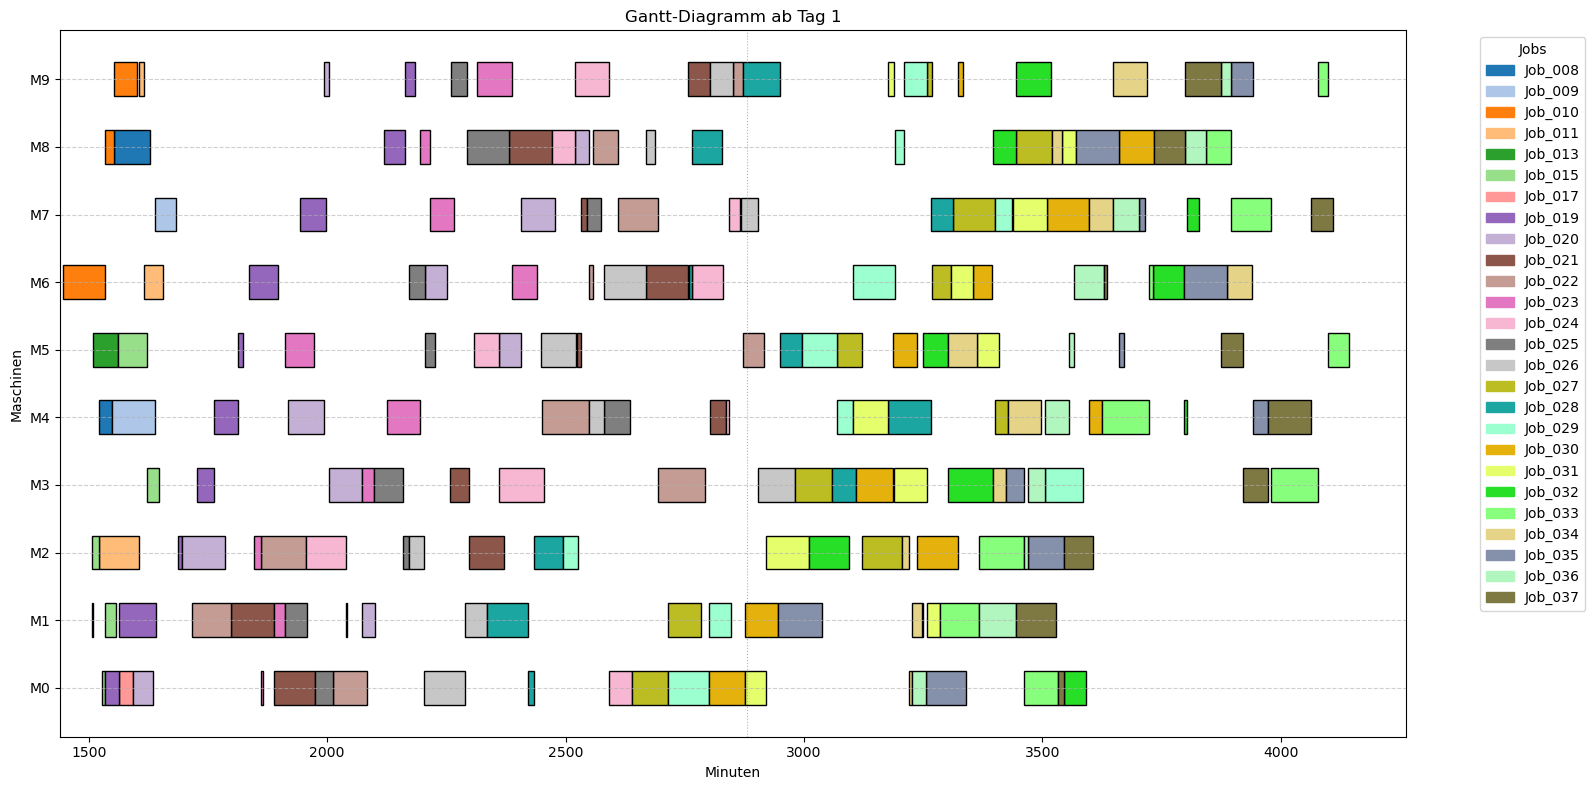

In [23]:
show.plot_gantt_machines(df_reschedule, title = f"Gantt-Diagramm ab Tag 1")

In [24]:
df_reschedule.to_csv(file_template.format(prefix="05", suffix="01_reschedule"), index = False)